In [1]:
!pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px

from imblearn.combine import SMOTETomek

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

from hyperopt import hp, fmin, Trials #to define th ehyperparamter space and fmin is the optimization function
from hyperopt import rand, anneal, tpe #search algorithms in hyperopt
from hyperopt import STATUS_OK, STATUS_FAIL


from sklearn.model_selection import cross_val_score
from skopt import gp_minimize

from skopt.plots import plot_convergence, plot_evaluations, plot_objective
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import make_scorer

In [4]:
df = pd.read_csv("C:/Users/bhara/HPTuning/heart_2020_cleaned.csv")

In [5]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [6]:
df = df.sample(n=50000, random_state=36)  # Sampling only 50,000 rows

In [7]:
print('No. of Records:',df.shape[0])
print('No. of Features:',df.shape[1])
print('Features:', df.columns)

No. of Records: 50000
No. of Features: 18
Features: Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 247477 to 77989
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      50000 non-null  object 
 1   BMI               50000 non-null  float64
 2   Smoking           50000 non-null  object 
 3   AlcoholDrinking   50000 non-null  object 
 4   Stroke            50000 non-null  object 
 5   PhysicalHealth    50000 non-null  float64
 6   MentalHealth      50000 non-null  float64
 7   DiffWalking       50000 non-null  object 
 8   Sex               50000 non-null  object 
 9   AgeCategory       50000 non-null  object 
 10  Race              50000 non-null  object 
 11  Diabetic          50000 non-null  object 
 12  PhysicalActivity  50000 non-null  object 
 13  GenHealth         50000 non-null  object 
 14  SleepTime         50000 non-null  float64
 15  Asthma            50000 non-null  object 
 16  KidneyDisease     50000 non-null  object

In [9]:
df.loc[:, 'HeartDisease'] = df['HeartDisease'].map({'Yes': 1, 'No': 0})

In [10]:
for i in df.columns:
    if df[i].dtype== "object":
        print(i,df[i].unique())

HeartDisease [0 1]
Smoking ['No' 'Yes']
AlcoholDrinking ['No' 'Yes']
Stroke ['No' 'Yes']
DiffWalking ['No' 'Yes']
Sex ['Female' 'Male']
AgeCategory ['60-64' '80 or older' '70-74' '35-39' '25-29' '75-79' '65-69' '50-54'
 '30-34' '45-49' '55-59' '18-24' '40-44']
Race ['Black' 'White' 'Other' 'Hispanic' 'Asian'
 'American Indian/Alaskan Native']
Diabetic ['No, borderline diabetes' 'No' 'Yes' 'Yes (during pregnancy)']
PhysicalActivity ['No' 'Yes']
GenHealth ['Very good' 'Good' 'Excellent' 'Fair' 'Poor']
Asthma ['No' 'Yes']
KidneyDisease ['No' 'Yes']
SkinCancer ['No' 'Yes']


In [11]:
X = df.drop('HeartDisease', axis=1)  # Now drop it from features
y = df['HeartDisease']  # Target variable
y = y.astype(int)

In [12]:
y.head()

247477    0
278680    1
271963    1
297024    1
165281    0
Name: HeartDisease, dtype: int64

In [13]:
X = pd.get_dummies(X,
                  columns=['Smoking', 'AlcoholDrinking', 'Stroke',
                           'DiffWalking', 'Sex', 'AgeCategory', 'Race',
                           'Diabetic', 'PhysicalActivity', 'GenHealth',
                           'Asthma', 'KidneyDisease', 'SkinCancer'],
                  drop_first=True)
X.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,AgeCategory_25-29,...,Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
247477,28.35,0.0,0.0,6.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
278680,22.05,0.0,0.0,6.0,True,False,False,False,True,False,...,False,False,True,False,True,False,False,True,False,False
271963,25.94,0.0,0.0,8.0,False,False,False,False,True,False,...,False,False,True,False,False,False,True,False,False,True
297024,35.87,0.0,0.0,8.0,True,False,True,False,True,False,...,False,False,True,False,False,False,True,True,False,False
165281,24.21,0.0,10.0,8.0,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False


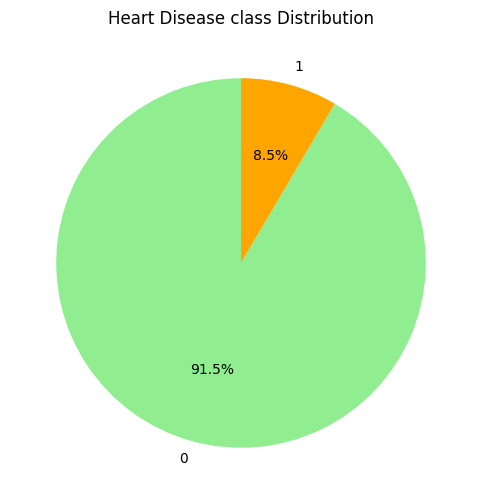

In [14]:
%matplotlib inline

# Count occurrences of each diagnosis
heartdisease_counts = df["HeartDisease"].value_counts()

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(heartdisease_counts, labels=heartdisease_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'orange'])
plt.title("Heart Disease class Distribution")
plt.show()

# Part 1: Random Forest with No Hyperparameters (Default values)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

model = RandomForestClassifier(random_state=36)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall_default = recall_score(y_test, y_pred)
print("Recall(with Default Hyperparameters): ", round(recall_default,3))
print("Accuracy(with Default Hyperparameters): ", round(accuracy,3))
print(classification_report(y_test, y_pred))

Recall(with Default Hyperparameters):  0.107
Accuracy(with Default Hyperparameters):  0.91
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9155
           1       0.38      0.11      0.17       845

    accuracy                           0.91     10000
   macro avg       0.65      0.55      0.56     10000
weighted avg       0.88      0.91      0.89     10000



              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9155
           1       0.38      0.11      0.17       845

    accuracy                           0.91     10000
   macro avg       0.65      0.55      0.56     10000
weighted avg       0.88      0.91      0.89     10000



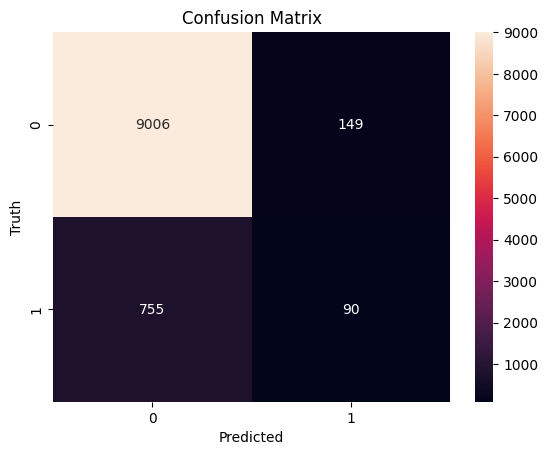

In [16]:
matrix = confusion_matrix(y_test, y_pred)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, y_pred))

# Resampling to avoid the class imbalance

In [17]:
SMOTE_TOMEK= SMOTETomek(random_state=36)
X_train_u, y_train_u = SMOTETomek().fit_resample(X_train, y_train)
y_train_u.value_counts()

HeartDisease
0    36529
1    36529
Name: count, dtype: int64

In [18]:
model1 = RandomForestClassifier(random_state=36)
model1.fit(X_train_u, y_train_u)
y_pred1 = model1.predict(X_test)
accuracy1 = accuracy_score(y_test, y_pred1)
recall1 = recall_score(y_test, y_pred1)
print("Accuracy(After balancing the distribution): ", round(accuracy1,3))
print("Recall(After balancing the distribution): ", round(recall1,3))
print(classification_report(y_test, y_pred1))

Accuracy(After balancing the distribution):  0.886
Recall(After balancing the distribution):  0.28
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      9155
           1       0.31      0.28      0.29       845

    accuracy                           0.89     10000
   macro avg       0.62      0.61      0.62     10000
weighted avg       0.88      0.89      0.88     10000



# Part 2: Random Forest Classification with Hyperparameters(GridSearchCV)

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {
    'n_estimators' : [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1,2,4],
    "max_features": ['sqrt', 'log2']
}
model_grid = RandomForestClassifier(random_state=36)
grid_search = GridSearchCV(estimator = model_grid,
                          param_grid = param_grid,
                          cv = 2,
                          n_jobs= -1,
                          verbose = True,
                          scoring = "recall")
grid_search.fit(X_train_u, y_train_u)
best_model_grid = grid_search.best_estimator_
y_pred_grid = best_model_grid.predict(X_test)
accuracy_grid = accuracy_score(y_test, y_pred_grid)
recall_grid = recall_score(y_test, y_pred_grid)
print("\n GridSearchCV Best Parameters:", grid_search.best_params_)
print("GridSearchCV Accuracy:", accuracy_grid)
print("GridSearchCV Recall:", recall_grid)
print(classification_report(y_test, y_pred_grid))

Fitting 2 folds for each of 288 candidates, totalling 576 fits

 GridSearchCV Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
GridSearchCV Accuracy: 0.8847
GridSearchCV Recall: 0.2781065088757396
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      9155
           1       0.30      0.28      0.29       845

    accuracy                           0.88     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.88      0.88      0.88     10000



Text(50.722222222222214, 0.5, 'Truth')

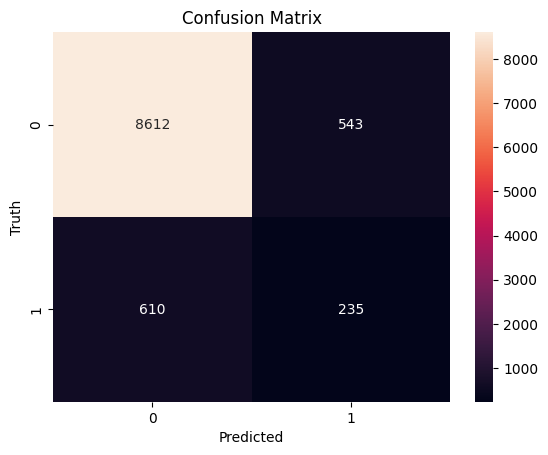

In [20]:
matrix = confusion_matrix(y_test, y_pred_grid)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Part 3: RandomForest Classification using RandomizedSearch

In [21]:
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(50, 200, num=10)],
    'max_depth': [None] + [int(x) for x in np.linspace(10, 50, num=5)],
    'min_samples_split': [int(x) for x in np.linspace(1, 200, num=5)],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [22]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
model_random = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=model_random,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=2,
                                   n_jobs=-1,
                                   verbose = True,
                                   random_state=36,
                                   scoring='recall')
random_search.fit(X_train_u, y_train_u)
best_rf_random = random_search.best_estimator_
y_pred_random = best_rf_random.predict(X_test)
accuracy_random = accuracy_score(y_test, y_pred_random)
recall_random = recall_score(y_test, y_pred_random)
print("\nRandomizedSearchCV Best Parameters:", random_search.best_params_)
print("RandomizedSearchCV Accuracy:", accuracy_random)
print("RandomizedSearchCV Recall:", recall_random)
print(classification_report(y_test, y_pred_random))

Fitting 2 folds for each of 100 candidates, totalling 200 fits


C:\Users\bhara\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
26 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\bhara\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bhara\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\bhara\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 666, in _validate_params
    valida


RandomizedSearchCV Best Parameters: {'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40}
RandomizedSearchCV Accuracy: 0.8545
RandomizedSearchCV Recall: 0.47218934911242605
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      9155
           1       0.28      0.47      0.35       845

    accuracy                           0.85     10000
   macro avg       0.62      0.68      0.64     10000
weighted avg       0.89      0.85      0.87     10000



Text(50.722222222222214, 0.5, 'Truth')

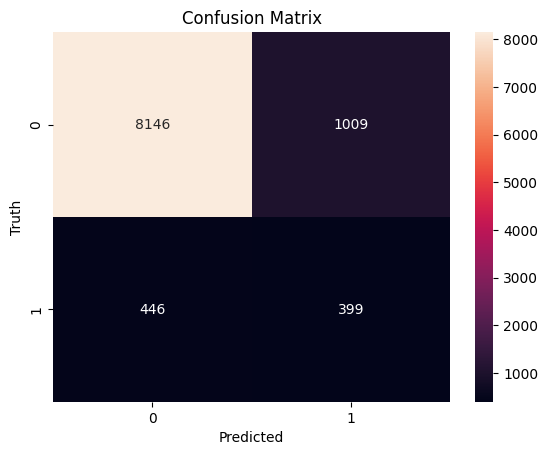

In [23]:
matrix = confusion_matrix(y_test, y_pred_random)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Part 4: Tuning using Hyperopt using random Search

In [24]:
# defining the hyperparamter space
param_grid = {
    'n_estimators': hp.randint('n_estimators', 50, 201),          # 50–200
    'max_depth': hp.randint('max_depth', 10, 101),                # 10–100
    'min_samples_split': hp.randint('min_samples_split', 2, 51),  # 2–50
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 21),    # 1–20
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),  # 'sqrt' or 'log2'
}

In [25]:
# Defining the objective function

def objective(params):
    params_dict = {
        'n_estimators': int(params['n_estimators']),
        'max_depth' : int(params['max_depth']),
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf':params['min_samples_leaf'],
        'max_features': params['max_features'],
        'random_state': 36
    }
    model = RandomForestClassifier(**params_dict) #with ** we are passing the items in the dictionary as paramters to the model
    score = cross_val_score(model,
                           X_train_u,
                           y_train_u,
                           scoring = "accuracy",
                           cv = 5,
                           n_jobs = -1)
    loss = -score.mean()
    loss_variance = score.std()

    try:
        return{
            'loss':loss,
            'loss_variance': loss_variance,
            'status': STATUS_OK
        }
    except Exception as e:
        return{
            'exception': str(e),
            'status': STATUS_FAIL
        }

In [26]:
# Randomized Search
from numpy.random import default_rng

trials = Trials()
random_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50,
    rstate=default_rng(36),  # Using the new RNG
    algo=rand.suggest,
    trials = trials,
)
random_search
#fmin performs the minimization
# rand.suggest samples the parameters at random

100%|██████████| 50/50 [09:45<00:00, 11.71s/trial, best loss: -0.9283724965775928]


{'max_depth': np.int64(53),
 'max_features': np.int64(0),
 'min_samples_leaf': np.int64(1),
 'min_samples_split': np.int64(16),
 'n_estimators': np.int64(149)}

In [27]:
trials.argmin

{'max_depth': np.int64(53),
 'max_features': np.int64(0),
 'min_samples_leaf': np.int64(1),
 'min_samples_split': np.int64(16),
 'n_estimators': np.int64(149)}

In [29]:
pd.DataFrame(trials.vals).head()

,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
0,73,1,11,27,72
1,30,1,6,10,91
2,22,0,17,30,73
3,41,0,13,39,140
4,70,1,5,19,165


In [30]:
pd.DataFrame(trials.results).head()

,loss,loss_variance,status
0,-0.884503,0.029522,ok
1,-0.900094,0.033214,ok
2,-0.876906,0.028609,ok
3,-0.883093,0.030359,ok
4,-0.901941,0.033685,ok


In [32]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by="loss", ascending=False).reset_index(drop=True)

results.head()

,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,loss,loss_variance,status
0,70,1,20,37,193,-0.872075,0.028061,ok
1,92,1,20,45,197,-0.872143,0.027527,ok
2,48,1,19,28,55,-0.873046,0.027691,ok
3,26,0,20,28,97,-0.873457,0.028105,ok
4,83,1,19,10,166,-0.873662,0.027972,ok


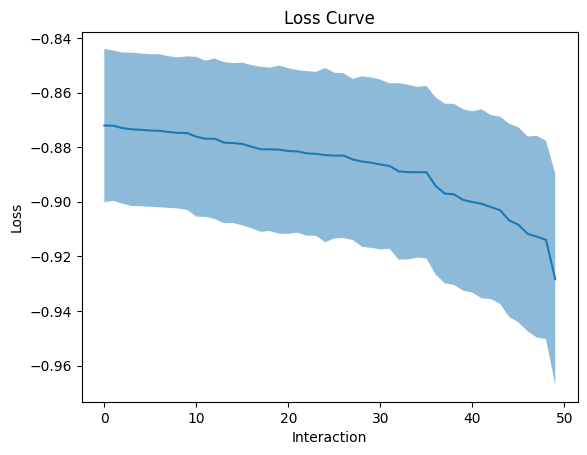

In [35]:
import seaborn as sb
import matplotlib.pyplot as plt

# Ensure 'index' is a column
results = results.reset_index()

# Plot with corrected column names
ax = sb.lineplot(x='index', y='loss', data=results)

# Fill between variance
ax.fill_between(
    results['index'],
    y1=results["loss"] - results["loss_variance"],
    y2=results["loss"] + results["loss_variance"],
    alpha=0.5,
)

plt.xlabel('Interaction')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()


In [36]:
# create  another dictionary to pass the search items as parameters to a new randomforest

def create_param_grid(search, max_features):
    best_hp_dict = {
        "n_estimators": search['n_estimators'],
        'max_depth': search['max_depth'],
        'min_samples_split' : search['min_samples_split'],
        'min_samples_leaf' : search['min_samples_leaf'],
        'max_features' : max_features,
        'random_state': 36
    }
    return best_hp_dict

In [37]:
# after the search we can train the model with the best parameters manually
best_params = create_param_grid(random_search, 'log2')
model_rand = RandomForestClassifier(**best_params)
model_rand.fit(X_train_u, y_train_u)
# Predict on the test set
y_pred_rand = model_rand.predict(X_test)

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_rand))

test_recall_rand = recall_score(y_test, y_pred_rand)
print("Test set recall:", test_recall_rand)
accuracy_rand = accuracy_score(y_test, y_pred_rand)
print("Accuracy(with Default Hyperparameters): ", round(accuracy_rand,3))


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      9155
           1       0.30      0.37      0.33       845

    accuracy                           0.87     10000
   macro avg       0.62      0.65      0.63     10000
weighted avg       0.89      0.87      0.88     10000

Test set recall: 0.37041420118343193
Accuracy(with Default Hyperparameters):  0.874


# Part 5: Tuning using Hyperopt using Anneal Search

In [39]:
# Annealing
trials_anneal = Trials()
anneal_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=100,
    rstate=default_rng(36),  # Using the new RNG
    algo=anneal.suggest,
    trials = trials_anneal,
)
anneal_search

100%|██████████| 100/100 [22:15<00:00, 13.36s/trial, best loss: -0.9417591600761742]


{'max_depth': np.int64(46),
 'max_features': np.int64(1),
 'min_samples_leaf': np.int64(1),
 'min_samples_split': np.int64(5),
 'n_estimators': np.int64(182)}

In [40]:
trials_anneal.argmin

{'max_depth': np.int64(46),
 'max_features': np.int64(1),
 'min_samples_leaf': np.int64(1),
 'min_samples_split': np.int64(5),
 'n_estimators': np.int64(182)}

In [41]:
pd.DataFrame(trials_anneal.vals).head()

,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
0,73,1,11,27,72
1,80,1,11,6,80
2,92,1,12,46,58
3,90,0,16,3,102
4,97,1,16,22,69


In [42]:
pd.DataFrame(trials_anneal.results).head()

,loss,loss_variance,status
0,-0.884503,0.029522,ok
1,-0.884503,0.030801,ok
2,-0.880233,0.029767,ok
3,-0.878905,0.029208,ok
4,-0.876468,0.028740,ok


In [44]:
results_anneal = pd.concat([
    pd.DataFrame(trials_anneal.vals),
    pd.DataFrame(trials_anneal.results)],
    axis=1,
).sort_values(by="loss", ascending=False).reset_index(drop=True)

results_anneal.head()

,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,loss,loss_variance,status
0,48,0,20,12,186,-0.874771,0.028077,ok
1,95,0,19,5,87,-0.874840,0.028127,ok
2,13,1,7,38,134,-0.875798,0.030021,ok
3,40,1,17,7,171,-0.875811,0.028765,ok
4,97,1,16,22,69,-0.876468,0.028740,ok


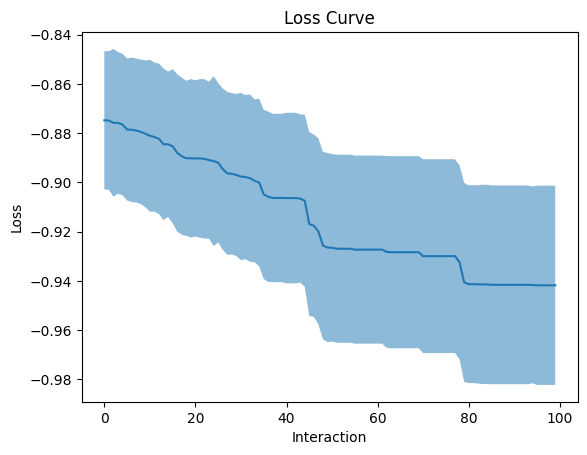

In [45]:
import seaborn as sb
import matplotlib.pyplot as plt

# Ensure 'index' is a column
results_anneal = results_anneal.reset_index()

# Plot with corrected column names
ax = sb.lineplot(x='index', y='loss', data=results_anneal)

# Fill between variance
ax.fill_between(
    results_anneal['index'],
    y1=results_anneal["loss"] - results_anneal["loss_variance"],
    y2=results_anneal["loss"] + results_anneal["loss_variance"],
    alpha=0.5,
)

plt.xlabel('Interaction')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()


In [46]:
best_params = create_param_grid(anneal_search, 'log2')
model_anneal = RandomForestClassifier(**best_params)
model_anneal.fit(X_train_u, y_train_u)
# Predict on the test set
y_pred_anneal = model_anneal.predict(X_test)

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_anneal))

test_recall_anneal = recall_score(y_test, y_pred_anneal)
print("Test set recall:", test_recall_anneal)
accuracy_anneal = accuracy_score(y_test, y_pred_anneal)
print("Accuracy(with Default Hyperparameters): ", round(accuracy_anneal,3))


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      9155
           1       0.33      0.30      0.31       845

    accuracy                           0.89     10000
   macro avg       0.63      0.62      0.63     10000
weighted avg       0.88      0.89      0.89     10000

Test set recall: 0.3005917159763314
Accuracy(with Default Hyperparameters):  0.888


# Part 6: Using Scikit-Optimize

In [47]:
#determine the HP Space
param_grid = [
    Integer(10, 200, name="n_estimators"),
    Integer(5, 100, name= "max_depth"),
    Integer(2, 200, name='min_samples_split'),
    Integer(1, 4, name='min_samples_leaf'),
    Categorical(['sqrt', 'log2'], name='max_features')    
]

In [48]:
model_optimize = RandomForestClassifier(random_state=36)

In [58]:
# defining the objective function

@use_named_args(param_grid)
def objective1(**params):
    model_optimize.set_params(**params)

    value = np.mean(
        cross_val_score(
            model_optimize,
            X_train_u,
            y_train_u,
            cv = 5,
            n_jobs = -1,
            scoring = "accuracy"
        )
    )
    return -value
    

In [59]:
# Using Random Forest as Surrogate
from skopt import forest_minimize
fm = forest_minimize(
    objective1,
    param_grid,
    base_estimator = "RF",
    n_initial_points = 10,
    acq_func = "EI",
    n_calls = 30,
    random_state = 36,
    n_jobs = -1
)
# Extract best parameters
best_params = dict(zip([p.name for p in param_grid], fm.x))
print("Best parameters:", best_params)


Best parameters: {'n_estimators': np.int64(47), 'max_depth': np.int64(91), 'min_samples_split': np.int64(16), 'min_samples_leaf': np.int64(2), 'max_features': np.str_('sqrt')}


In [60]:
model_optimize.set_params(**best_params)
model_optimize.fit(X_train_u, y_train_u)

# Predict on the test set
y_pred_optimize = model_optimize.predict(X_test)

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_optimize))

test_recall_optimize = recall_score(y_test, y_pred_optimize)
print("Test set recall:", test_recall_optimize)
accuracy = accuracy_score(y_test, y_pred_optimize)
print("Accuracy(with Default Hyperparameters): ", round(accuracy,3))


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      9155
           1       0.29      0.40      0.33       845

    accuracy                           0.87     10000
   macro avg       0.61      0.65      0.63     10000
weighted avg       0.89      0.87      0.88     10000

Test set recall: 0.39644970414201186
Accuracy(with Default Hyperparameters):  0.866


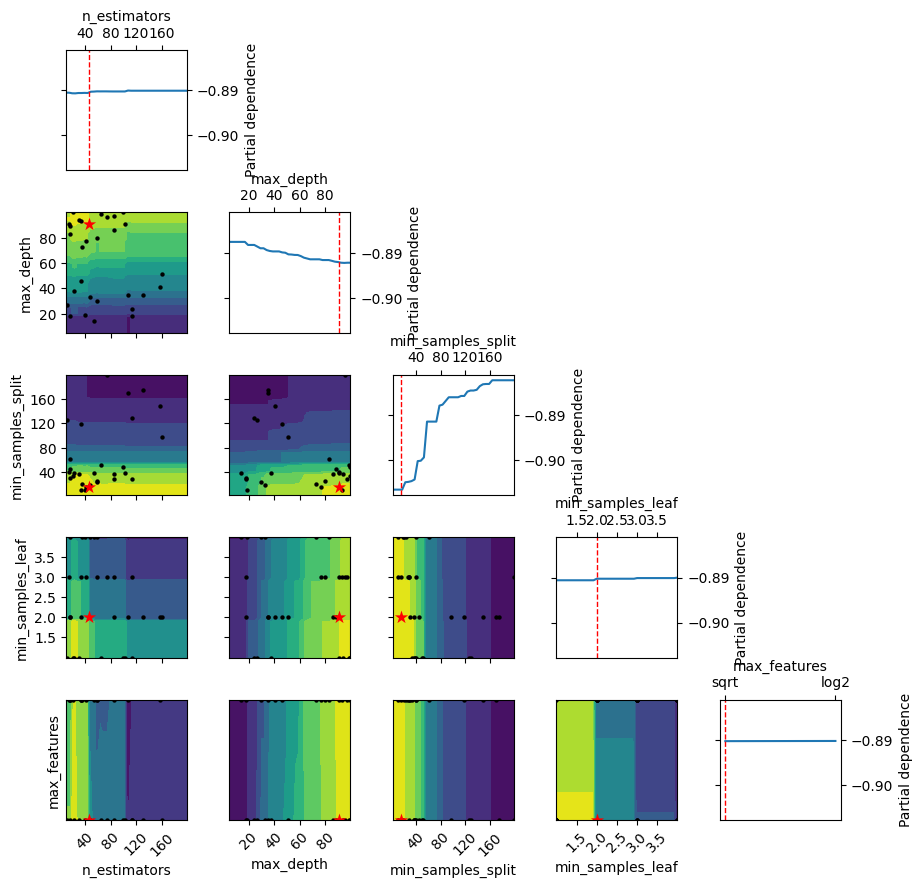

In [61]:
dim_names = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']
plot_objective(result=fm, plot_dims = dim_names)
plt.show()

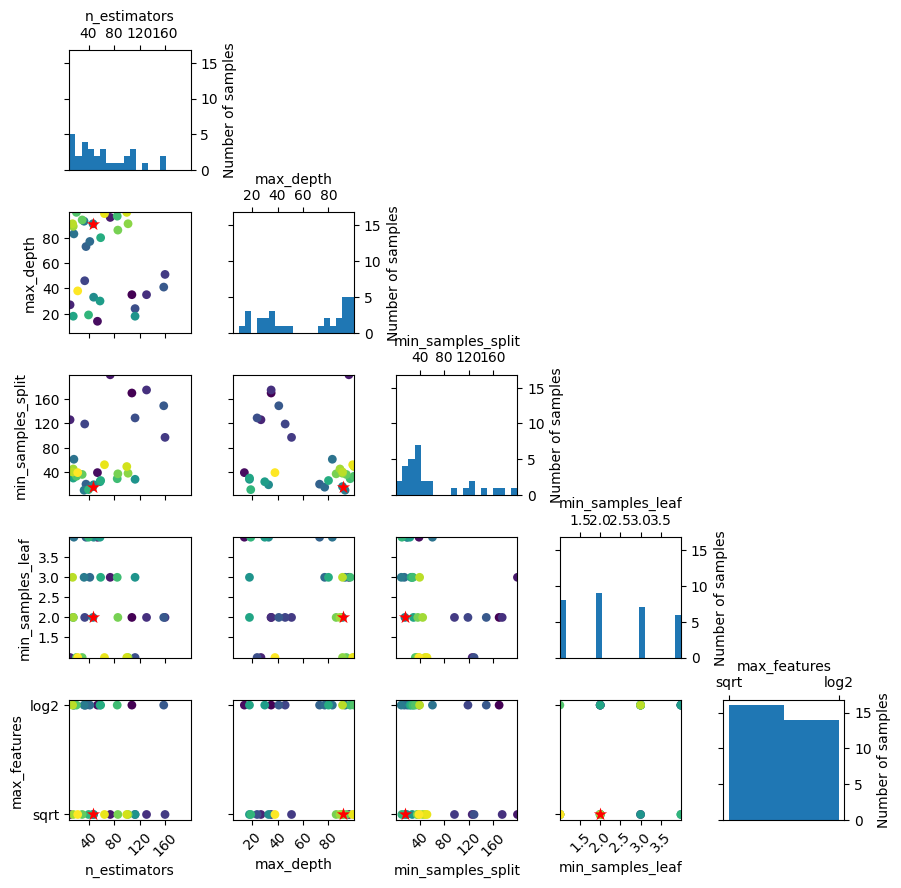

In [62]:
plot_evaluations(result=fm, plot_dims = dim_names)
plt.show()


Comparison of Results:
                   Model    Recall
0  Default RF_imbalanced  0.106509
1             Default RF  0.280473
2           GridSearchCV  0.278107
3     RandomizedSearchCV  0.472189
4  Hyperopt_RandomSearch  0.370414
5  Hyperopt_AnnealSearch  0.300592
6        Scikit_optimize  0.396450


C:\Users\bhara\AppData\Local\Temp\ipykernel_27196\4116500455.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Model', y='Recall', data=results_df, palette='viridis')


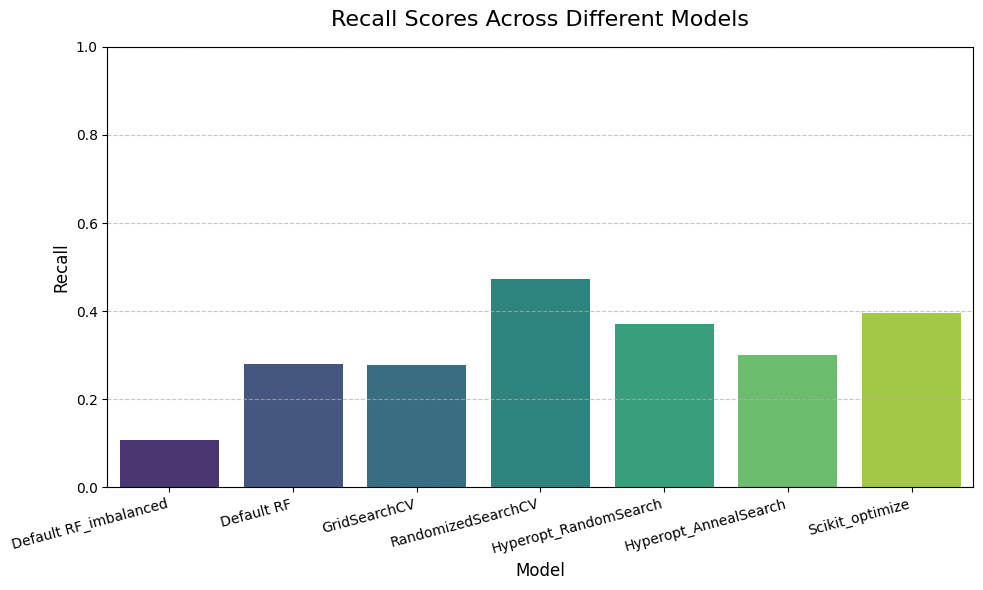

In [63]:
results = {
    'Model': ['Default RF_imbalanced', 'Default RF', 'GridSearchCV', 'RandomizedSearchCV','Hyperopt_RandomSearch', 'Hyperopt_AnnealSearch','Scikit_optimize'],
    'Recall': [recall_default, recall1, recall_grid, recall_random, test_recall_rand, test_recall_anneal, test_recall_optimize]
}
results_df = pd.DataFrame(results)

# Set up the plot
plt.figure(figsize=(10, 6))
sb.barplot(x='Model', y='Recall', data=results_df, palette='viridis')
plt.title('Recall Scores Across Different Models', fontsize=16, pad=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

print("\nComparison of Results:")
print(results_df)
plt.tight_layout()
plt.show()

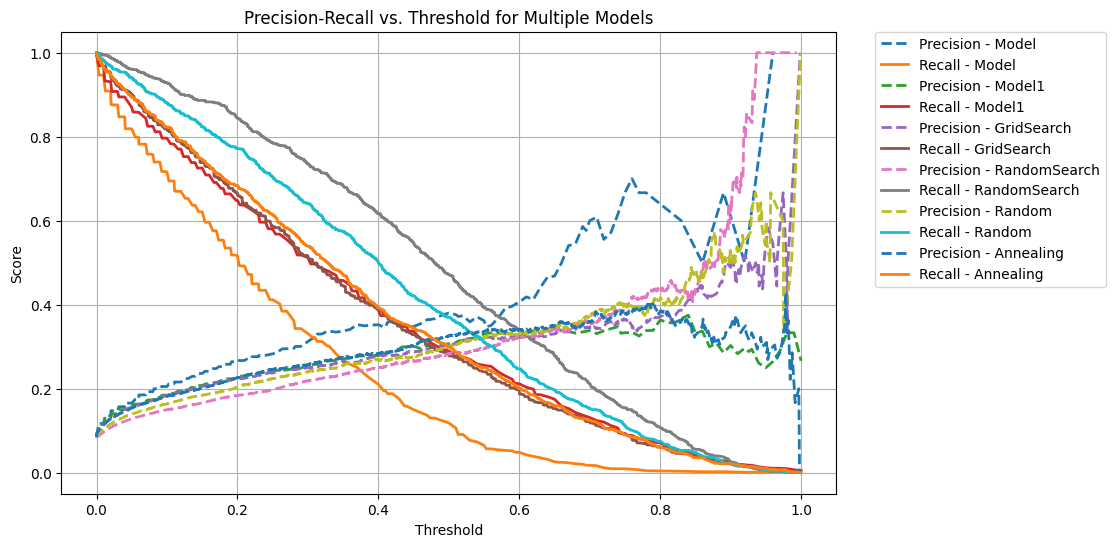

Best Model: RandomSearch
Best Threshold: 0.4131
Best Precision: 0.2543
Best Recall: 0.6000


In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

def plot_precision_recall(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 6))
    
    best_model = None
    best_recall = 0
    best_threshold = 0
    best_precision = 0
    best_name = ""
    
    for model, name in zip(models, model_names):
        y_probs = model.predict_proba(X_test)[:, 1]  # Getting probability for positive class
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
        
        plt.plot(thresholds, precisions[:-1], label=f"Precision - {name}", linestyle='dashed',linewidth=2)
        plt.plot(thresholds, recalls[:-1], label=f"Recall - {name}", linestyle='solid', linewidth=2)
        
        #threshold with recall between 0.6 to 0.7
        for i, recall in enumerate(recalls):
            if 0.6 <= recall <= 0.7:
                if precisions[i] > best_precision:
                    best_recall = recall
                    best_precision = precisions[i]
                    best_threshold = thresholds[i]
                    best_name = name
    
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision-Recall vs. Threshold for Multiple Models")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid()
    plt.show()
    
    print(f"Best Model: {best_name}")
    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best Precision: {best_precision:.4f}")
    print(f"Best Recall: {best_recall:.4f}")
    

# List of models and their names
models = [model, model1, best_model_grid, best_rf_random, model_rand, model_anneal]
model_names = ["Model", "Model1", "GridSearch", "RandomSearch", "Random", "Annealing"]

# Call function to plot
plot_precision_recall(models, model_names, X_test, y_test)


In [85]:
y_pred_best = (best_rf_random.predict_proba(X_test)[:, 1] >= 0.4131).astype(int)
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred_best))


Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.96      0.84      0.89      9155
           1       0.25      0.60      0.36       845

    accuracy                           0.82     10000
   macro avg       0.61      0.72      0.63     10000
weighted avg       0.90      0.82      0.85     10000

